<a href="https://colab.research.google.com/github/lukasdekanovsky/Become_PythonDeveloper_AI/blob/main/REKURENT_(1D_CNN)_Zpracov%C3%A1n%C3%AD_textu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Zpracování textu a přirozeného jazyka**

# 1) **Import knihoven**

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


Další podstatnou částí je tokenizer a pad_sequences
* Tokenizer - doplní každému slovu index
* pad_sequences - zarovná věty podle té nejdelší, u všech kratších doplní na prázdná místa 0

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

# 2) **Proces TOKENIZACE**

* Ja jsem Pavel -> Ja = 1, jsem = 2, Pavel = 3 -> [1, 2, 3, 0]
* Ja jsem mila Alena -> Ja = 1, jsem = 2, mila = 4, Alena = 5 -> [1, 2, 4, 5]

**Příklad**

In [ ]:
vety = ["Ja jsem Pavel", "Ja jsem mila Alena", "My jsme osklivi lide"]

MAX_SLOV = 20000 #MAX_VOCABULARY_SIZE
tokenizer = Tokenizer(num_words=MAX_SLOV)
tokenizer.fit_on_texts(vety) #ocislovani jake slovo ma jake cislo
sekvence = tokenizer.texts_to_sequences(vety) #ocisluj vety v kolekci
print(sekvence)
tokenizer.word_index

[[1, 2, 3], [1, 2, 4, 5], [6, 7, 8, 9]]


{'ja': 1,
 'jsem': 2,
 'pavel': 3,
 'mila': 4,
 'alena': 5,
 'my': 6,
 'jsme': 7,
 'osklivi': 8,
 'lide': 9}

In [ ]:
data = pad_sequences(sekvence, padding="post")
print(data)

[[1 2 3 0]
 [1 2 4 5]
 [6 7 8 9]]


# **Reálná data - detekce spamu**

1) Stažení dat

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2022-11-19 12:55:58--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.06s   

2022-11-19 12:55:58 (7.56 MB/s) - ‘spam.csv’ saved [503663/503663]



2) Kontrola dat

In [ ]:
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

3) Načtení dat do dataframu a jejich úprava - ham/spam = 0/1

In [ ]:
df = pd.read_csv("spam.csv", encoding="ISO-8859-1")
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1) #zahodí sloupce
df.columns = ["labels", "data"]
df["bin_labels"] = df["labels"].map({"ham": 0, "spam": 1})
df.head(11)

,labels,data,bin_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
6,ham,Even my brother is not like to speak with me. ...,0
7,ham,As per your request 'Melle Melle (Oru Minnamin...,0
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1


4) Rozdělení datové sady

In [ ]:
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], df['bin_labels'].values, test_size=0.33)

In [ ]:
print(len(df_train), len(df_test)) # v jakém poměru máme trénovací a testovací

3733 1839


5) Provedeme TOKENIZACI - !!! tokenizace musí být stejná i pro testovací - jinak by měla kompletně odlišné indexy pro jednotlivá slova

In [ ]:
MAX_SLOV = 20000
tokenizer = Tokenizer(num_words=MAX_SLOV)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

6) Zobrazíme si počet unikátních slov

In [ ]:
V = len(tokenizer.word_index)
print(V)
print(tokenizer.word_index)

7258
{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'call': 16, 'have': 17, 'that': 18, 'on': 19, '2': 20, 'are': 21, 'now': 22, 'so': 23, 'or': 24, 'but': 25, 'can': 26, 'do': 27, 'not': 28, 'ur': 29, 'if': 30, "i'm": 31, 'at': 32, 'will': 33, 'with': 34, 'get': 35, 'be': 36, 'no': 37, 'we': 38, 'just': 39, 'gt': 40, 'this': 41, 'lt': 42, '4': 43, 'when': 44, 'up': 45, 'how': 46, 'all': 47, 'out': 48, 'ok': 49, 'free': 50, 'good': 51, 'go': 52, 'what': 53, 'know': 54, 'from': 55, 'like': 56, 'then': 57, 'its': 58, 'was': 59, 'come': 60, 'time': 61, 'got': 62, 'am': 63, 'only': 64, 'love': 65, 'text': 66, 'want': 67, 'day': 68, 'send': 69, 'he': 70, 'need': 71, 'one': 72, 'going': 73, 'txt': 74, 'there': 75, 'lor': 76, 'sorry': 77, 'as': 78, 'r': 79, 'home': 80, 'still': 81, 'by': 82, 'about': 83, "i'll": 84, 'back': 85, 'stop': 86, 'k': 87, 'our': 88, 'see': 89, 'she': 90, 'later': 91, 'r

7) Jaká je nejdelší věta

In [ ]:
data_train = pad_sequences(sequences_train)
T = data_train.shape[1]
print(T)

189


8) Stejným způsobem musíme useknout i testovací data

In [ ]:
data_test = pad_sequences(sequences_test, maxlen=T)
G = data_test.shape[1]
print(G)

189


9) Vytvoření modelu neuronové sítě

In [ ]:
D = 20 #nema vyznam - hyperparametr
M = 15 #pocet skrytych stavu - hyperparametr LSTM site

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i) #klidne zamenit za data_test[1] / T
x = LSTM(M, return_sequences=True)(x) #pametova vrstva
x = GlobalMaxPooling1D()(x) #matematicka statistika (feel free to zamenit za avg)
x = Dense(1, activation="sigmoid")(x)

model = Model(i, x)

10) Kompilace modelu

In [ ]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

11) Učení modelu

In [ ]:
r = model.fit(data_train, Ytrain, epochs=10, validation_data = (data_test, Ytest))

Epoch 1/10
117/117 [==============================] - 14s 88ms/step - loss: 0.4581 - accuracy: 0.8642 - val_loss: 0.3815 - val_accuracy: 0.8695
Epoch 2/10
117/117 [==============================] - 11s 92ms/step - loss: 0.3606 - accuracy: 0.8642 - val_loss: 0.3199 - val_accuracy: 0.8695
Epoch 3/10
117/117 [==============================] - 11s 95ms/step - loss: 0.2919 - accuracy: 0.8642 - val_loss: 0.2568 - val_accuracy: 0.8695
Epoch 4/10
117/117 [==============================] - 22s 191ms/step - loss: 0.2106 - accuracy: 0.8658 - val_loss: 0.1836 - val_accuracy: 0.9451
Epoch 5/10
117/117 [==============================] - 12s 106ms/step - loss: 0.1291 - accuracy: 0.9831 - val_loss: 0.1226 - val_accuracy: 0.9782
Epoch 6/10
117/117 [==============================] - 11s 91ms/step - loss: 0.0730 - accuracy: 0.9912 - val_loss: 0.0940 - val_accuracy: 0.9826
Epoch 7/10
117/117 [==============================] - 10s 87ms/step - loss: 0.0474 - accuracy: 0.9941 - val_loss: 0.0804 - val_accurac

12) Vykreslení ztrátové funkce a přesnosti

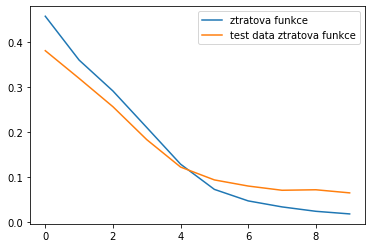

In [ ]:
plt.plot(r.history["loss"], label="ztratova funkce")
plt.plot(r.history["val_loss"], label="test data ztratova funkce")
plt.legend()

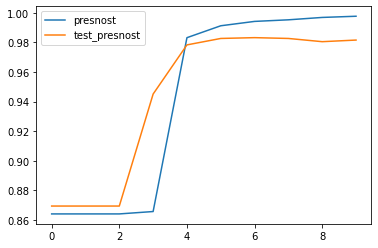

In [ ]:
plt.plot(r.history["accuracy"], label="presnost")
plt.plot(r.history["val_accuracy"], label="test_presnost")
plt.legend()

13) Vložení vlastní věty pro detekci spamu

In [ ]:
veta = "Free entry in 2 a wkly comp to win FA Cup final to receive entry question"
veta = [veta]
veta = tokenizer.texts_to_sequences(veta)
veta = pad_sequences(veta, maxlen=T)
sance_spam = model(veta).numpy()[0][0]
print(f"sance, ze veta je spam je: {sance_spam*100}%")

sance, ze veta je spam je: 97.27359414100647%
